In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/NN_Project/captcha_dataset.zip

In [ ]:
#importing libraries
import numpy as np

%matplotlib inline
#to use as command line calls #using inline graphs will come next to code

import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
import tensorflow.keras.backend as K

In [ ]:
#total no of images in dataset
n=len(os.listdir("/content/samples"))
n

1070

In [ ]:
#defining size of image
imgshape=(50,200,1) #50-height, 200-width, 1-no of channels

In [ ]:
character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [ ]:
#preprocesss image
def preprocess():
  X = np.zeros((n,50,200,1)) #1070*50*200 array with all entries 0
  y = np.zeros((5,n,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir("/content/samples")):
  #i represents index no. of image in directory
  #pic contains the file name of the particular image to be preprocessed at a time

    img = cv2.imread(os.path.join("/content/samples", pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    pic_target = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training

    if len(pic_target) < 6: #captcha is not more than 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (50, 200, 1)) #reshapes image to width 200 , height 50 ,channel 1

      target=np.zeros((5,nchar)) #creates an array of size 5*36 with all entries 0

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [ ]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25

    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers

    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.layers import Reshape, Permute, LSTM

def create_model_with_lstm():
    img = Input(shape=imgshape)  # Get image as an input of shape (height, width, channels)
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)  # 50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)  # To improve the stability of the model

    # Reshape the data to match the expected input shape for the Bidirectional LSTM layers
    permuted = Permute((2, 1, 3))(bn)
    reshaped = Reshape((50, 13 * 64))(permuted)

    # Add Bidirectional LSTM layers here
    blstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(reshaped)
    blstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(blstm1)

    # Continue with the rest of your code
    flat = layers.Flatten()(blstm2)

    outs = []
    for _ in range(5):  # For 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)  # Drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)
        outs.append(res)  # Result of layers

    # Compile the model and return it
    model = Model(img, outs)  # Create the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
#Create model
model=create_model_with_lstm();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']   

In [ ]:
X,y=preprocess()

In [ ]:
#split the 1070 samples where 970 samples will be used for training purpose
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [ ]:
#Applying the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=35, epochs=60, validation_split=0.2, verbose = 1)
#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Epoch 1/60
23/23 [==============================] - 24s 123ms/step - loss: 17.3356 - dense_1_loss: 3.4627 - dense_3_loss: 3.4390 - dense_5_loss: 3.4674 - dense_7_loss: 3.4981 - dense_9_loss: 3.4685 - dense_1_accuracy: 0.0503 - dense_3_accuracy: 0.0528 - dense_5_accuracy: 0.0696 - dense_7_accuracy: 0.0554 - dense_9_accuracy: 0.0619 - val_loss: 17.6386 - val_dense_1_loss: 3.5155 - val_dense_3_loss: 3.5222 - val_dense_5_loss: 3.5269 - val_dense_7_loss: 3.5428 - val_dense_9_loss: 3.5312 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.0619 - val_dense_5_accuracy: 0.1134 - val_dense_7_accuracy: 0.0464 - val_dense_9_accuracy: 0.0567
Epoch 2/60
23/23 [==============================] - 1s 43ms/step - loss: 16.1899 - dense_1_loss: 3.2357 - dense_3_loss: 3.2267 - dense_5_loss: 3.2592 - dense_7_loss: 3.2912 - dense_9_loss: 3.1771 - dense_1_accuracy: 0.0979 - dense_3_accuracy: 0.0670 - dense_5_accuracy: 0.0838 - dense_7_accuracy: 0.0825 - dense_9_accuracy: 0.1044 - val_loss: 17.4775 - val_

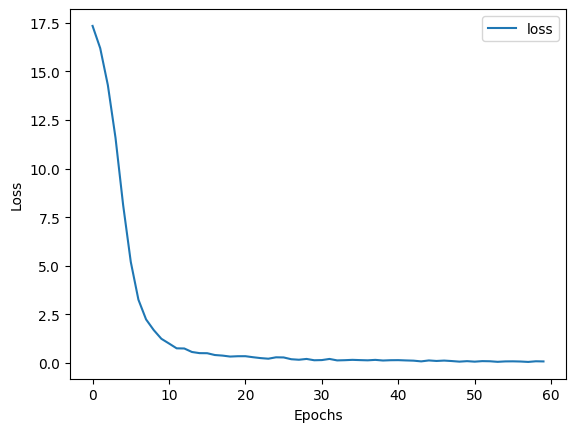

In [ ]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
#Loss on training set
#Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))
print ("Accuracy on training set= " + str(preds[10]))

31/31 [==============================] - 1s 22ms/step - loss: 0.1209 - dense_1_loss: 0.0041 - dense_3_loss: 0.0192 - dense_5_loss: 0.0446 - dense_7_loss: 0.0475 - dense_9_loss: 0.0054 - dense_1_accuracy: 0.9979 - dense_3_accuracy: 0.9938 - dense_5_accuracy: 0.9876 - dense_7_accuracy: 0.9876 - dense_9_accuracy: 0.9959
Loss on training set= 0.12092465162277222
Accuracy on training set= 0.9958763122558594


In [ ]:
#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set= " + str(preds[0]))
print ("Accuracy on testing set= " + str(preds[10]))

4/4 [==============================] - 0s 27ms/step - loss: 0.7182 - dense_1_loss: 0.0084 - dense_3_loss: 0.0033 - dense_5_loss: 0.2140 - dense_7_loss: 0.3719 - dense_9_loss: 0.1207 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9600 - dense_7_accuracy: 0.9300 - dense_9_accuracy: 0.9800
Loss on testing set= 0.7182325124740601
Accuracy on testing set= 0.9800000190734863


In [ ]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36
    result = np.reshape(res, (5, 36)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt

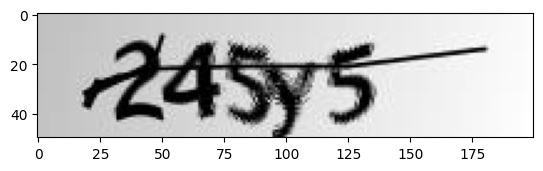

In [ ]:
#Check model on samples
img=cv2.imread('/content/samples/245y5.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))


In [ ]:
print("Predicted Captcha =",predict('/content/samples/245y5.png'))

1/1 [==============================] - 2s 2s/step
Predicted Captcha = 245y5


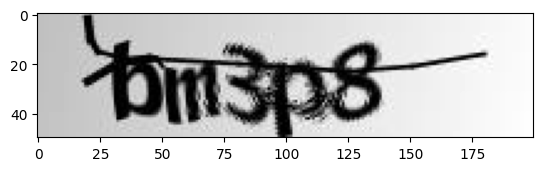

In [ ]:
#Sample 2
img=cv2.imread('/content/samples/bm3p8.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
print("Predicted Captcha =",predict('/content/samples/bm3p8.png'))

1/1 [==============================] - 0s 23ms/step
Predicted Captcha = bm3p8


# Model Summary
<table style="font-size: 30px;">
  <tr>
    <th>Size of the dataset:</th>
    <th>1,070</th>
  </tr>
  <tr>
    <th>Number of epochs:</th>
    <th>60</th>
  </tr>
  <tr>
    <th>Batch Size:</th>
    <th>35</th>
  </tr>
  <tr>
    <th>Training Loss</th>
    <th>0.12092</th>
  </tr>
  <tr>
    <th>Training Accuracy</th>
    <th>0.99587</th>
  </tr>
  <tr>
    <th>Testing Loss</th>
    <th>0.71823</th>
  </tr>
  <tr>
    <th>Testing Accuracy</th>
    <th>0.98000</th>
  </tr>
</table>